# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size = 10  #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = 120
            z = 120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            ct_img=0
            #             print("batch: ",batch)

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                ct_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                     
                    image_resized=resize(image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        ct_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                ct_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=resize(image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
#             print("\nbatchlast:", batch," ct_imglast: ",ct_img, "pathlast:", source_path)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path='train/'
val_path= 'val/'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model1 - Conv3D layers + BatchNormalization

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, AveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

#write your model here
curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
frames=15
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser ='Adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_1 (Average (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 16)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val/ ; batch size = Source path =  train/ ; batch size = 10
10Epoch 1/15



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 2s - loss: 1.6125 - categorical_accuracy: 0.2242

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 165s 2s/step - loss: 1.6152 - categorical_accuracy: 0.2269 - val_loss: 1.4922 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2021-02-0513_13_54.434066/model-00001-1.61517-0.22687-1.49222-0.28000.h5
Epoch 2/15
67/67 [==============================] - 70s 1s/step - loss: 1.5190 - categorical_accuracy: 0.2881 - val_loss: 1.6989 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2021-02-0513_13_54.434066/model-00002-1.51904-0.28806-1.69894-0.29000.h5
Epoch 3/15
67/67 [==============================] - 70s 1s/step - loss: 1.5027 - categorical_accuracy: 0.3478 - val_loss: 1.4196 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2021-02-0513_13_54.434066/model-00003-1.50266-0.34776-1.41955-0.35000.h5
Epoch 4/15
67/67 [==============================] - 69s 1s/step - loss: 1.4130 - categorical_accuracy: 0.3806 - val_loss: 1.2343 - val_categorical_accuracy: 0.5400

Epoch 00004

    Now we will write a function to repeat the above process for subsequent models

In [13]:
# Function to build model
def buildmodel(model,epochsize,batchsize, optimiser, lr):
    
    # Set batch size and epoch
    batch_size = batchsize #experiment with the batch size
    num_epochs = epochsize # choose the number of epochs
    
    # Optimizer and compile
    from keras.optimizers import Adam
    if(optimiser=="Adam"):
        optimiser = Adam(lr) #write your optimizer
    elif(optimiser=="sgd"):
        optimiser="sgd"
        
    
    # Now that you have written the model, the next step is to `compile` the model. 
    # When you print the `summary` of the model, you'll see the total number of parameters you have to train.
    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    # Create Generators
    # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    # Save h5 files
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    # write the REducelronplateau code here
#     LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) 
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) 
    
    callbacks_list = [checkpoint, LR]
    
    # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() 
    # calls it need to make.
    # Epoch Calculation
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save 
    # the model at the end of each epoch.
    # Build Model
    model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    import matplotlib.pyplot as plt 
    # visualise training history
    plt.plot(model1.history['categorical_accuracy'])
    plt.plot(model1.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()

    # summarize history for loss
    plt.plot(model1.history['loss'])
    plt.plot(model1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return model1

In [16]:
from keras import regularizers

### Model2 - Conv3D layers + Dropout + BatchNormalization + L2 Regularization

In [17]:
# model2

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model2 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_10 (Averag (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 60, 60, 16)     64        
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 2.1854 - categorical_accuracy: 0.2348

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 62s 926ms/step - loss: 2.1895 - categorical_accuracy: 0.2358 - val_loss: 1.8899 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2021-02-0513_41_21.659316/model-00001-2.18955-0.23582-1.88987-0.33000.h5
Epoch 2/10
67/67 [==============================] - 58s 862ms/step - loss: 1.7760 - categorical_accuracy: 0.3090 - val_loss: 2.4125 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0513_41_21.659316/model-00002-1.77599-0.30896-2.41254-0.23000.h5
Epoch 3/10
67/67 [==============================] - 65s 965ms/step - loss: 1.6122 - categorical_accuracy: 0.3866 - val_loss: 2.4565 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2021-02-0513_41_21.659316/model-00003-1.61221-0.38657-2.45645-0.18000.h5
Epoch 4/10
67/67 [==============================] - 57s 856ms/step - loss: 1.4943 - categorical_accuracy: 0.4269 - val_loss: 1.6179 - val_categorical_accuracy: 0.3100



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

#### Model3 - Conv3D layers + More Layers + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_21 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 15, 120, 120, 8)   520       
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_22 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 120, 120, 8)   0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


65/67 [============================>.] - ETA: 1s - loss: 2.4654 - categorical_accuracy: 0.1692

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 61s 906ms/step - loss: 2.4649 - categorical_accuracy: 0.1642 - val_loss: 2.2000 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-02-0513_52_10.270855/model-00001-2.46485-0.16418-2.19997-0.23000.h5
Epoch 2/10
67/67 [==============================] - 54s 806ms/step - loss: 2.1023 - categorical_accuracy: 0.1985 - val_loss: 2.0035 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0513_52_10.270855/model-00002-2.10231-0.19851-2.00354-0.23000.h5
Epoch 3/10
67/67 [==============================] - 58s 866ms/step - loss: 1.9462 - categorical_accuracy: 0.1746 - val_loss: 1.8815 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-02-0513_52_10.270855/model-00003-1.94622-0.17463-1.88148-0.21000.h5
Epoch 4/10
67/67 [==============================] - 60s 903ms/step - loss: 1.8449 - categorical_accuracy: 0.2030 - val_loss: 1.8028 - val_categorical_accuracy: 0.2300



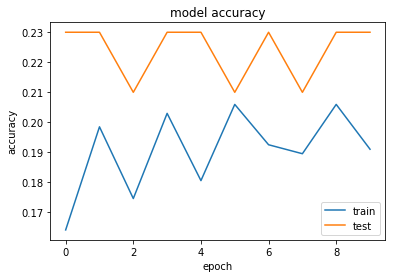

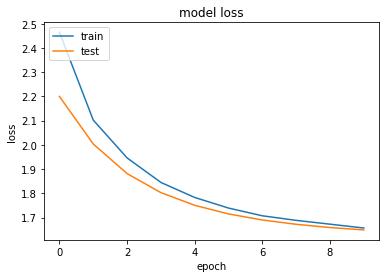

In [18]:

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model3 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model4 - Conv3D layers + More Layers + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_33 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_19 (Averag (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_26 (Batc (None, 7, 60, 60, 16)     64        
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 3.1584 - categorical_accuracy: 0.2076

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 62s 929ms/step - loss: 3.1582 - categorical_accuracy: 0.2075 - val_loss: 2.8120 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-02-0514_02_53.206674/model-00001-3.15822-0.20746-2.81204-0.23000.h5
Epoch 2/10
67/67 [==============================] - 57s 853ms/step - loss: 2.6655 - categorical_accuracy: 0.2045 - val_loss: 2.5165 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0514_02_53.206674/model-00002-2.66547-0.20448-2.51653-0.23000.h5
Epoch 3/10
67/67 [==============================] - 65s 975ms/step - loss: 2.4167 - categorical_accuracy: 0.2030 - val_loss: 2.3155 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-02-0514_02_53.206674/model-00003-2.41674-0.20299-2.31547-0.23000.h5
Epoch 4/10
67/67 [==============================] - 55s 823ms/step - loss: 2.2441 - categorical_accuracy: 0.1866 - val_loss: 2.1620 - val_categorical_accuracy: 0.1800



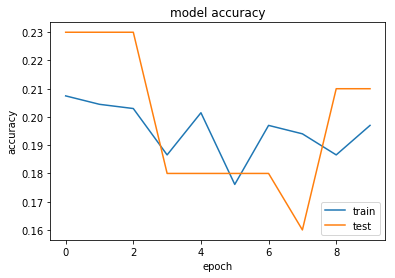

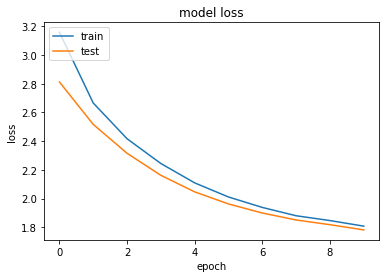

In [20]:

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model4 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model5 - Conv3D layers + Larger Dense Layer + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 15, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
activation_41 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 15, 120, 120, 16)  0         
_________________________________________________________________
average_pooling3d_25 (Averag (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 60, 60, 32)     128       
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


65/67 [============================>.] - ETA: 2s - loss: 4.4945 - categorical_accuracy: 0.2062

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 68s 1s/step - loss: 4.4668 - categorical_accuracy: 0.2119 - val_loss: 3.3724 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-02-0514_13_19.400492/model-00001-4.46678-0.21194-3.37237-0.22000.h5
Epoch 2/10
67/67 [==============================] - 52s 769ms/step - loss: 2.8641 - categorical_accuracy: 0.1806 - val_loss: 2.5594 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2021-02-0514_13_19.400492/model-00002-2.86407-0.18060-2.55943-0.18000.h5
Epoch 3/10
67/67 [==============================] - 61s 911ms/step - loss: 2.2655 - categorical_accuracy: 0.2075 - val_loss: 2.0657 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-02-0514_13_19.400492/model-00003-2.26546-0.20746-2.06567-0.21000.h5
Epoch 4/10
67/67 [==============================] - 55s 815ms/step - loss: 1.9652 - categorical_accuracy: 0.2015 - val_loss: 1.8714 - val_categorical_accuracy: 0.2100

Epo

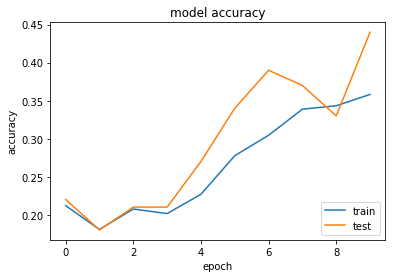

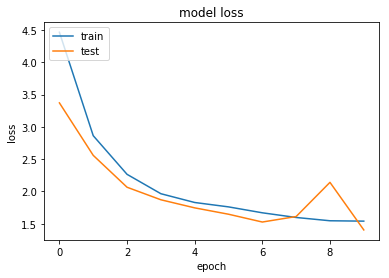

In [22]:
curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [16,32,64,128]
nb_dense = [64, 64, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model5 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model6 - Conv3D layers + Larger Dense Layer + Dropout  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 15, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
activation_45 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 15, 120, 120, 16)  0         
_________________________________________________________________
average_pooling3d_28 (Averag (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_38 (Batc (None, 7, 60, 60, 32)     128       
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


65/67 [============================>.] - ETA: 1s - loss: 3.1633 - categorical_accuracy: 0.2538

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 59s 879ms/step - loss: 3.1365 - categorical_accuracy: 0.2552 - val_loss: 1.4913 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-3.13649-0.25522-1.49131-0.29000.h5
Epoch 2/10
67/67 [==============================] - 57s 845ms/step - loss: 1.6642 - categorical_accuracy: 0.2597 - val_loss: 1.4905 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-1.66419-0.25970-1.49051-0.37000.h5
Epoch 3/10
67/67 [==============================] - 57s 849ms/step - loss: 1.5123 - categorical_accuracy: 0.3299 - val_loss: 1.3634 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-1.51234-0.32985-1.36344-0.50000.h5
Epoch 4/10
67/67 [==============================] - 57s 847ms/step - loss: 1.3895 - categorical_accuracy: 0.3791 - val_loss: 1.2891 - val_categorical_accuracy: 0.4800



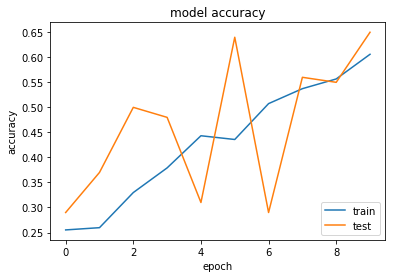

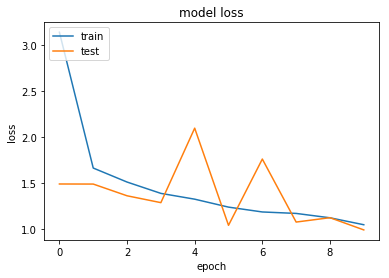

In [23]:
# model6

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [16,32,64,128]
nb_dense = [256,128,64,5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[2], activation='relu'))
model.add(Dropout(0.25))
          


#softmax layer
model.add(Dense(nb_dense[3], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model6 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Conv2D Layers 

In [24]:
# Import libraries for building model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.regularizers import l2

### Conv2D layers + GRU Layer + No dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 15, 15, 64)    18496     
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 1.3134 - categorical_accuracy: 0.4424

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 66s 990ms/step - loss: 1.3312 - categorical_accuracy: 0.4358 - val_loss: 1.0590 - val_categorical_accuracy: 0.6100

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.33116-0.43582-1.05901-0.61000.h5
Epoch 2/10
67/67 [==============================] - 50s 742ms/step - loss: 0.9954 - categorical_accuracy: 0.5985 - val_loss: 0.9899 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-0.99543-0.59851-0.98988-0.64000.h5
Epoch 3/10
67/67 [==============================] - 65s 970ms/step - loss: 0.8084 - categorical_accuracy: 0.6851 - val_loss: 1.0736 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-0.80843-0.68507-1.07360-0.57000.h5
Epoch 4/10
67/67 [==============================] - 55s 821ms/step - loss: 0.6277 - categorical_accuracy: 0.7687 - val_loss: 1.5411 - val_categorical_accuracy: 0.4100



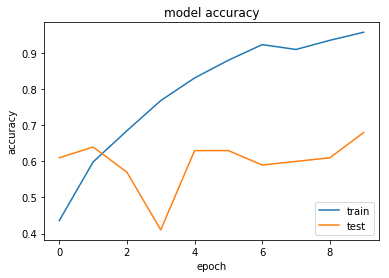

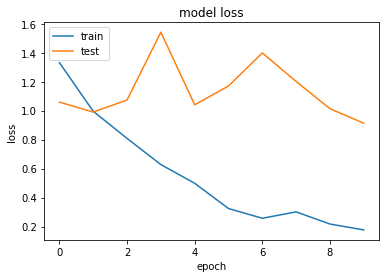

In [25]:
# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dense(nb_dense[2], activation='relu'))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model1 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model2 - Conv2D layers + GRU Layer +  dropout 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 1.4608 - categorical_accuracy: 0.3530

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 63s 939ms/step - loss: 1.4758 - categorical_accuracy: 0.3522 - val_loss: 1.3083 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.47584-0.35224-1.30835-0.41000.h5
Epoch 2/10
67/67 [==============================] - 51s 761ms/step - loss: 1.1951 - categorical_accuracy: 0.4866 - val_loss: 1.0820 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-1.19515-0.48657-1.08195-0.53000.h5
Epoch 3/10
67/67 [==============================] - 55s 819ms/step - loss: 1.1093 - categorical_accuracy: 0.5493 - val_loss: 1.7493 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-1.10932-0.54925-1.74932-0.27000.h5
Epoch 4/10
67/67 [==============================] - 53s 795ms/step - loss: 0.9655 - categorical_accuracy: 0.5985 - val_loss: 1.4958 - val_categorical_accuracy: 0.4900



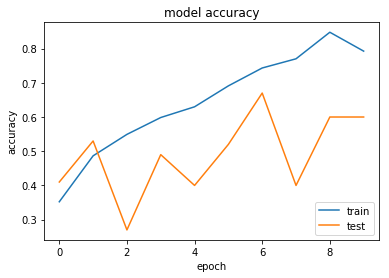

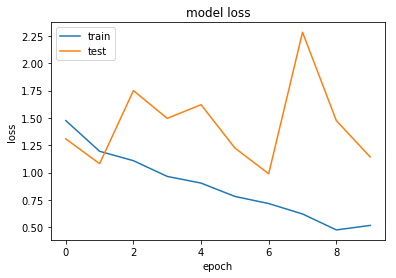

In [26]:
# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dense(nb_dense[2], activation='relu'))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model2 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model3 - Conv2D layers + GRU Layer +  dropout  + L2 regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 4.4930 - categorical_accuracy: 0.3500

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 64s 951ms/step - loss: 4.4934 - categorical_accuracy: 0.3537 - val_loss: 3.6126 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-4.49340-0.35373-3.61261-0.51000.h5
Epoch 2/10
67/67 [==============================] - 51s 760ms/step - loss: 3.2409 - categorical_accuracy: 0.4910 - val_loss: 3.1472 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-3.24089-0.49104-3.14716-0.34000.h5
Epoch 3/10
67/67 [==============================] - 56s 830ms/step - loss: 2.5024 - categorical_accuracy: 0.5433 - val_loss: 3.4992 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-2.50240-0.54328-3.49924-0.33000.h5
Epoch 4/10
67/67 [==============================] - 54s 810ms/step - loss: 2.0186 - categorical_accuracy: 0.5970 - val_loss: 2.4008 - val_categorical_accuracy: 0.4800



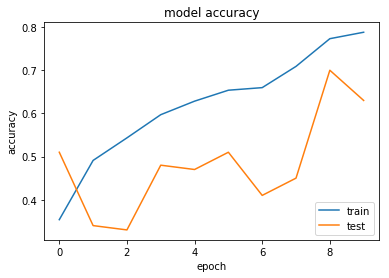

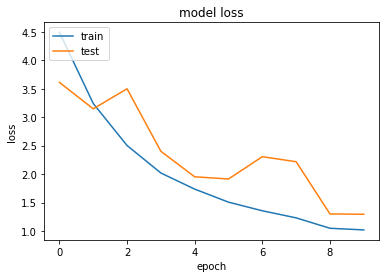

In [27]:
# Model3

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nb_dense[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nb_dense[2], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model3 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model4 - Conv2D layers + LSTM Layer +  dropout  + L2 regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


66/67 [============================>.] - ETA: 0s - loss: 4.1264 - categorical_accuracy: 0.4182

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 63s 936ms/step - loss: 4.1280 - categorical_accuracy: 0.4164 - val_loss: 3.1867 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-4.12795-0.41642-3.18672-0.51000.h5
Epoch 2/10
67/67 [==============================] - 51s 756ms/step - loss: 2.8988 - categorical_accuracy: 0.4716 - val_loss: 2.5001 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-2.89882-0.47164-2.50007-0.46000.h5
Epoch 3/10
67/67 [==============================] - 67s 998ms/step - loss: 2.2279 - categorical_accuracy: 0.5104 - val_loss: 2.3522 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-2.22788-0.51045-2.35216-0.41000.h5
Epoch 4/10
67/67 [==============================] - 59s 879ms/step - loss: 1.8439 - categorical_accuracy: 0.5657 - val_loss: 1.8851 - val_categorical_accuracy: 0.5400



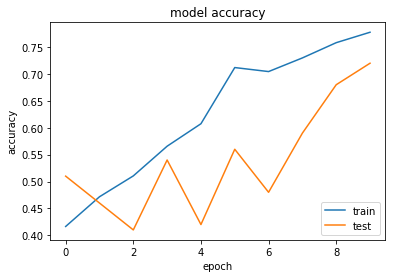

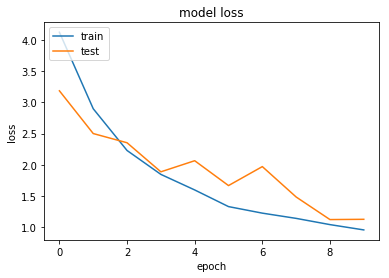

In [28]:
# Model4

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nb_dense[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nb_dense[2], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(dropout))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model4 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model5 - Transfer Learning + RestNet50 + GRU Layer 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_53 (TimeDis (None, 15, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 8192)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                1585344   
_________________________________________________________________
dropout_75 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (D

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


56/67 [========================>.....] - ETA: 20s - loss: 1.6933 - categorical_accuracy: 0.2321

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 122s 2s/step - loss: 1.7006 - categorical_accuracy: 0.2299 - val_loss: 1.6001 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.70057-0.22985-1.60008-0.24000.h5
Epoch 2/10
67/67 [==============================] - 88s 1s/step - loss: 1.6269 - categorical_accuracy: 0.2776 - val_loss: 1.6217 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-1.62686-0.27761-1.62171-0.23000.h5
Epoch 3/10
67/67 [==============================] - 88s 1s/step - loss: 1.5750 - categorical_accuracy: 0.3269 - val_loss: 1.6229 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-1.57498-0.32687-1.62285-0.23000.h5
Epoch 4/10
67/67 [==============================] - 88s 1s/step - loss: 1.5326 - categorical_accuracy: 0.3448 - val_loss: 1.6837 - val_categorical_accuracy: 0.2400

Epoch 00004

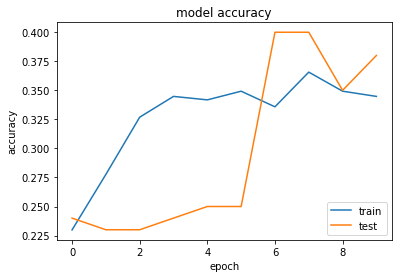

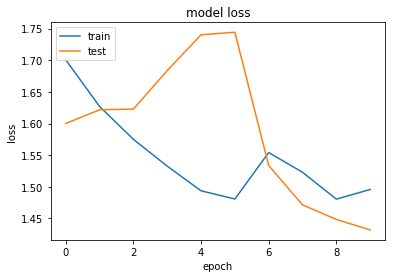

In [30]:
 #Model5

# Libraries for ResNet
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model5 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model6 - Transfer Learning + mobilenet + GRU Layer 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (D

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


65/67 [============================>.] - ETA: 2s - loss: 1.2803 - categorical_accuracy: 0.4585

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 72s 1s/step - loss: 1.2858 - categorical_accuracy: 0.4627 - val_loss: 0.9835 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.28583-0.46269-0.98353-0.62000.h5
Epoch 2/10
67/67 [==============================] - 52s 779ms/step - loss: 0.7063 - categorical_accuracy: 0.7209 - val_loss: 0.5718 - val_categorical_accuracy: 0.7700

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-0.70628-0.72090-0.57176-0.77000.h5
Epoch 3/10
67/67 [==============================] - 63s 947ms/step - loss: 0.4562 - categorical_accuracy: 0.8313 - val_loss: 0.4400 - val_categorical_accuracy: 0.8900

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-0.45623-0.83134-0.44004-0.89000.h5
Epoch 4/10
67/67 [==============================] - 66s 987ms/step - loss: 0.4143 - categorical_accuracy: 0.8597 - val_loss: 0.3321 - val_categorical_accuracy: 0.8200

Epo

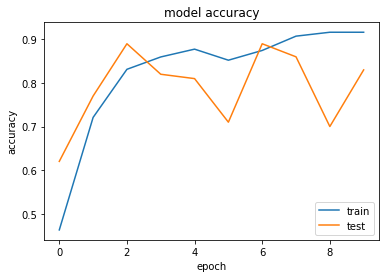

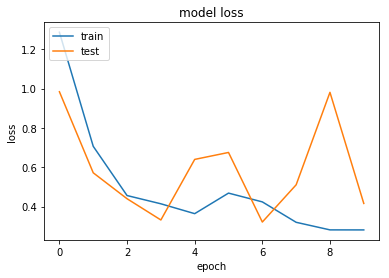

In [31]:
# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model6 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model7 - Transfer Learning + mobilenet + GRU Layer  + Increased epoch

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_61 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_79 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


65/67 [============================>.] - ETA: 2s - loss: 1.3356 - categorical_accuracy: 0.4292

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - 77s 1s/step - loss: 1.3264 - categorical_accuracy: 0.4358 - val_loss: 0.8697 - val_categorical_accuracy: 0.6500

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.32642-0.43582-0.86973-0.65000.h5
Epoch 2/15
67/67 [==============================] - 55s 821ms/step - loss: 0.7056 - categorical_accuracy: 0.7567 - val_loss: 0.5456 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-0.70562-0.75672-0.54564-0.75000.h5
Epoch 3/15
67/67 [==============================] - 63s 936ms/step - loss: 0.5074 - categorical_accuracy: 0.8373 - val_loss: 0.5019 - val_categorical_accuracy: 0.7700

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-0.50735-0.83731-0.50192-0.77000.h5
Epoch 4/15
67/67 [==============================] - 63s 945ms/step - loss: 0.4982 - categorical_accuracy: 0.8254 - val_loss: 0.7157 - val_categorical_accuracy: 0.7200

Epo

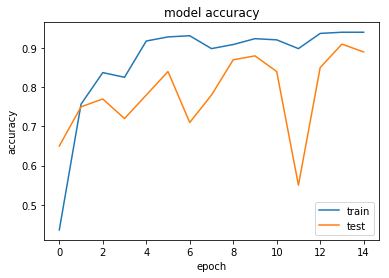

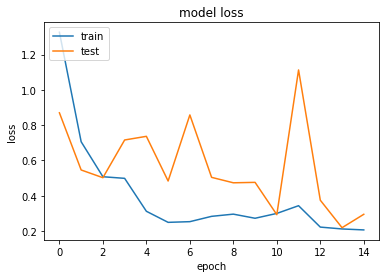

In [32]:
# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model7 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

### Model8 - Transfer Learning + mobilenet + GRU Layer  + Increased epoch + Increase Batch Size

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_66 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_67 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


32/34 [===========================>..] - ETA: 4s - loss: 1.3699 - categorical_accuracy: 0.4250

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 77s 2s/step - loss: 1.3698 - categorical_accuracy: 0.4338 - val_loss: 0.8415 - val_categorical_accuracy: 0.6800

Epoch 00001: saving model to model_init_2021-02-0514_23_30.215137/model-00001-1.36983-0.43382-0.84146-0.68000.h5
Epoch 2/15
34/34 [==============================] - 51s 1s/step - loss: 0.6475 - categorical_accuracy: 0.7794 - val_loss: 0.7910 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_init_2021-02-0514_23_30.215137/model-00002-0.64752-0.77941-0.79097-0.69000.h5
Epoch 3/15
34/34 [==============================] - 62s 2s/step - loss: 0.3277 - categorical_accuracy: 0.8985 - val_loss: 0.4939 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2021-02-0514_23_30.215137/model-00003-0.32769-0.89853-0.49388-0.80000.h5
Epoch 4/15
34/34 [==============================] - 63s 2s/step - loss: 0.2295 - categorical_accuracy: 0.9397 - val_loss: 0.7350 - val_categorical_accuracy: 0.7400

Epoch 00004:

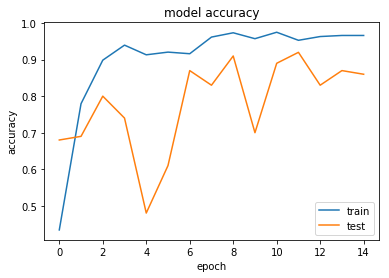

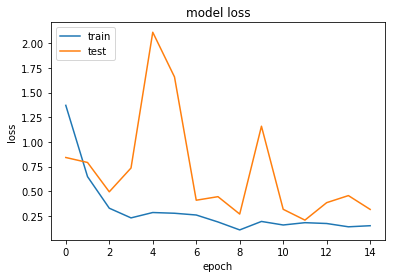

In [33]:
# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 20 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model8 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)